### Buscar questões do dataset Chave

In [1]:
import manager_dataset as _md

questions = _md.questions()

### Pré-processamento no texto das questões

In [2]:
import numpy as np
import random
import nltk

X = []
y = []

cls = {}

for question in questions:
    
    if question['question'] is None:
        continue
    
    clss = question['class']
    
    if clss == None:
        continue
    if clss == 'X':
        continue
    if clss == 'MANNER':
        continue
    if clss == 'OBJECT':
        continue
    if clss == 'OTHER':
        continue
    
    if clss not in cls:
        cls[clss] = 0
    cls[clss] += 1
    
    text = question['question']
    text = text.replace('\n', '').replace('\r', '')
    text = text.replace('?', ' ? ').replace('.', ' . ').replace(',', ' , ')
    text = text.replace(':', ' : ').replace(';', ' ; ')
    text = text.replace('\'', ' \" ').replace('\"', ' \" ')
    text = text.replace(u'«', ' \" ').replace(u'»', ' \" ')
    text = text.lower()
    question['question'] = text
    
    text = nltk.word_tokenize(text)
    X.append(text)
    y.append(clss)

                
print ('X:',len(X),' y:',len(y))
random.seed(1)
a = list(zip(X, y))
random.shuffle(a)
X, y = zip(*a)
X, y = np.array(X), np.array(y)
print (cls)

X: 2973  y: 2973
{'TIME': 364, 'PERSON': 582, 'LOCATION': 545, 'MEASURE': 502, 'DEFINITION': 624, 'ORGANIZATION': 356}


### Modelo Word2Vec

In [3]:
%%time
import numpy as np
from gensim.models import KeyedVectors


cbow_w2v_300 = 'data/word_embedding/cbow_s300.txt'

mw2v_300 = KeyedVectors.load_word2vec_format(cbow_w2v_300, unicode_errors="ignore")
print ('.')
w2v_300 = {w: vec for w, vec in zip(mw2v_300.index2word, mw2v_300.syn0)}

C:\ProgramData\Anaconda3\lib\site-packages\gensim\utils.py:860: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


.
Wall time: 3min 32s


### Modelos de representação em vetor

In [4]:
import numpy as np
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


def count_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return CountVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


def tfidf_vectorizer(MIN_GRAM=1, MAX_GRAM=1, LOWER=True):
    return TfidfVectorizer(analyzer=lambda x: x, strip_accents=None, ngram_range=(MIN_GRAM, MAX_GRAM), 
                           token_pattern=u'(?u)\\b\\w+\\b', lowercase=LOWER)


class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
    
    def fit(self, X, y):
        return self

    def transform(self, X):
        ret = np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        return ret

class HybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            bow = self.bow.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, bow[0]]))
        ret = np.array(ret)
        return ret

class TfidfHybridVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.tf = tfidf_vectorizer()
        
    
    def fit(self, X, y):
        self.tf.fit(X)
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            w2v = np.mean([self.word2vec[w] for w in sentence if w in self.word2vec] 
                    or [np.zeros(self.dim)], axis=0)
            tf = self.tf.transform([sentence]).toarray()
            ret.append(np.concatenate([w2v, tf[0]]))
        ret = np.array(ret)
        return ret

class SequenceHybridVectorizer(object):
    def __init__(self, word2vec, tfidf=False):
        self.word2vec = word2vec
        self.dim = len(word2vec)
        self.word2weight = None
        self.tfidf = tfidf
        self.bow = count_vectorizer()
        
    
    def fit(self, X, y):
        self.bow.fit(X)
        tfidf = tfidf_vectorizer()
        tfidf.fit(X)
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf, 
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])
        return self

    def transform(self, X):
        ret = []
        for sentence in X:
            vector = np.array([])
            maxWords = 32
            count = 0
            for word in sentence:
                if count < maxWords:
                    if word in self.word2vec:
                        count += 1
                        if self.tfidf:
                            vector = np.concatenate([vector, self.word2vec[word] * self.word2weight[word]])
                        else:
                            vector = np.concatenate([vector, self.word2vec[word]])
            for i in range(maxWords-count):
                vector = np.concatenate([vector, np.zeros(self.dim)])
            bow = self.bow.transform([sentence]).toarray()
            vector = np.concatenate([vector, bow[0]])
            ret.append(vector)
        
        ret = np.array(ret)
        return ret

## Definir classificadores

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.ensemble import ExtraTreesClassifier


classifiers = {}  # {'classifier': (VectorizeModel, Classifier)}

In [6]:
lbs = ["BoW_WF", 
       "BoW_TFIDF", 
       "W2V",
       "BoW_WF_W2V",
       "BoW_TFIDF_W2V"
        ]

#### SVM Linear

In [7]:
classifiers[lbs[0]] = (LinearSVC(), count_vectorizer())

In [8]:
classifiers[lbs[1]] = (LinearSVC(), tfidf_vectorizer())

In [9]:
classifiers[lbs[2]] = (LinearSVC(), MeanEmbeddingVectorizer(w2v_300))

In [10]:
classifiers[lbs[3]] = (LinearSVC(), HybridVectorizer(w2v_300))

In [11]:
classifiers[lbs[4]] = (LinearSVC(), TfidfHybridVectorizer(w2v_300))

In [ ]:
classifiers["Hybrid sequence"] = (LinearSVC(), SequenceHybridVectorizer(w2v_300))

In [ ]:
classifiers["Linear"] = (LinearSVC(), count_vectorizer())

In [ ]:
classifiers["Polynomial"] = (SVC(kernel="poly", degree=3, gamma=0.4), count_vectorizer())

In [ ]:
classifiers["RBF"] = (SVC(kernel="rbf", gamma=0.1), count_vectorizer())

In [ ]:
classifiers["Sigmoid"] = (SVC(kernel="sigmoid"), count_vectorizer())

#### Naive Bayes

In [ ]:
classifiers["NB mult"] = (MultinomialNB(), count_vectorizer())

In [ ]:
classifiers["NB mult tfidf"] = (MultinomialNB(), tfidf_vectorizer())

In [ ]:
classifiers["NB bernoulli"] = (BernoulliNB(), count_vectorizer())

In [ ]:
classifiers["NB bern tfidf"] = (BernoulliNB(), tfidf_vectorizer())

#### ExtraTrees

In [ ]:
classifiers["ETree"] = (ExtraTreesClassifier(n_estimators=200), count_vectorizer())

In [ ]:
classifiers["ETree tfidf"] = (ExtraTreesClassifier(n_estimators=200), tfidf_vectorizer())

In [ ]:
classifiers["ETree W2V"] = (ExtraTreesClassifier(n_estimators=200), MeanEmbeddingVectorizer(w2v_300))

## Testes

In [ ]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def benchmark(model, X, y, n):
    test_size = 1 - (n / float(len(y)))
    scores = {}
    for train, test in StratifiedShuffleSplit(y, n_iter=5, test_size=test_size, random_state=0):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        result = model.fit(X_train, y_train).predict(X_test)
        scores['accuracy'] = accuracy_score(result, y_test)
        scores['precision'] = precision_score(result, y_test, average="macro")
        scores['recall'] = recall_score(result, y_test, average="macro")
        scores['f1'] = f1_score(result, y_test, average="macro")
        scores['confusion'] = confusion_matrix(result, y_test)
    return scores

train_sizes = [80, 160, 240, 320, 400, 480, 560, 640, 720, 800, 880, 960, 1040, 1120, 1200, 1280, 1360, 
               1440, 1520, 1600, 1680, 1760, 1840, 1920, 2000, 2080, 2160, 2240, 2320, 2400, 2480]

table = []

def test_model(model, name):
    for n in train_sizes:
        result = benchmark(model, X, y, n)
        table.append({'Model': name, 
                      'accuracy': np.mean(result['accuracy']),
                      'precision': np.mean(result['precision']),
                      'recall': np.mean(result['recall']),
                      'f1': np.mean(result['f1']),
                      #'confusion': np.mean(result['confusion'], axis=0),
                      'train_size': n})
        print (name,'-',n)


In [12]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix

def benchmark(model, X, y, n):
    scores = {}
    for train, test in StratifiedShuffleSplit(y, n_iter=n, random_state=0):
        X_train, X_test = X[train], X[test]
        y_train, y_test = y[train], y[test]
        result = model.fit(X_train, y_train).predict(X_test)
        scores['accuracy'] = accuracy_score(result, y_test)
        scores['precision'] = precision_score(result, y_test, average="macro")
        scores['recall'] = recall_score(result, y_test, average="macro")
        scores['f1'] = f1_score(result, y_test, average="macro")
        scores['confusion'] = confusion_matrix(result, y_test)
    return scores

ks = list(reversed(list(range(30+1))[1:]))

table = []

def test_model(model, name):
    for n in ks:
        result = benchmark(model, X, y, n)
        table.append({'Model': name, 
                      'accuracy': np.mean(result['accuracy']),
                      'precision': np.mean(result['precision']),
                      'recall': np.mean(result['recall']),
                      'f1': np.mean(result['f1']),
                      #'confusion': np.mean(result['confusion'], axis=0),
                      'train_size': n})
        print (name,'-',n)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [ ]:
print (classifiers[lbs[0]])

In [13]:
%%time
for name in lbs:
    model = Pipeline([("vector_model", classifiers[name][1]), ("classifer", classifiers[name][0])])
    test_model(model, name)

BoW_WF - 30
BoW_WF - 29
BoW_WF - 28
BoW_WF - 27
BoW_WF - 26
BoW_WF - 25
BoW_WF - 24
BoW_WF - 23
BoW_WF - 22
BoW_WF - 21
BoW_WF - 20
BoW_WF - 19
BoW_WF - 18
BoW_WF - 17
BoW_WF - 16
BoW_WF - 15
BoW_WF - 14
BoW_WF - 13
BoW_WF - 12
BoW_WF - 11
BoW_WF - 10
BoW_WF - 9
BoW_WF - 8
BoW_WF - 7
BoW_WF - 6
BoW_WF - 5
BoW_WF - 4
BoW_WF - 3
BoW_WF - 2
BoW_WF - 1
BoW_TFIDF - 30
BoW_TFIDF - 29
BoW_TFIDF - 28
BoW_TFIDF - 27
BoW_TFIDF - 26
BoW_TFIDF - 25
BoW_TFIDF - 24
BoW_TFIDF - 23
BoW_TFIDF - 22
BoW_TFIDF - 21
BoW_TFIDF - 20
BoW_TFIDF - 19
BoW_TFIDF - 18
BoW_TFIDF - 17
BoW_TFIDF - 16
BoW_TFIDF - 15
BoW_TFIDF - 14
BoW_TFIDF - 13
BoW_TFIDF - 12
BoW_TFIDF - 11
BoW_TFIDF - 10
BoW_TFIDF - 9
BoW_TFIDF - 8
BoW_TFIDF - 7
BoW_TFIDF - 6
BoW_TFIDF - 5
BoW_TFIDF - 4
BoW_TFIDF - 3
BoW_TFIDF - 2
BoW_TFIDF - 1
W2V - 30
W2V - 29
W2V - 28
W2V - 27
W2V - 26
W2V - 25
W2V - 24
W2V - 23
W2V - 22
W2V - 21
W2V - 20
W2V - 19
W2V - 18
W2V - 17
W2V - 16
W2V - 15
W2V - 14
W2V - 13
W2V - 12
W2V - 11
W2V - 10
W2V - 9
W2V - 8
W2V

In [ ]:
import thread
        
for name in classifiers:
    model = Pipeline([("vector_model", classifiers[name][1]), ("classifer", classifiers[name][0])])
    thread.start_new_thread(test_model, (model, name, ))

[Text(0,0.5,'F1-Score')]

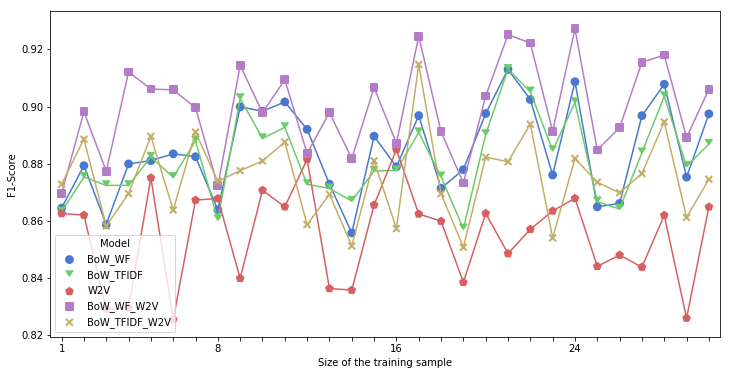

In [14]:
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

names = lbs
df = pd.DataFrame(table)

aux = df[df.Model.map(lambda x: x in names)]

sorterIndex = dict(zip(lbs,range(len(lbs))))
aux['models_sort'] = aux['Model'].map(sorterIndex)
aux.sort_values(['Model'], \
        ascending = [1], inplace = True)
aux.drop('models_sort', 1, inplace = True)


col_list = ["black", "black", "black", "black", "black"]
col_list_palette = sns.xkcd_palette(col_list)
#sns.set_palette(col_list_palette)
sns.set_palette(sns.color_palette("muted", 5))


#df = df.drop('accuracy', 1).drop('precision', 1).drop('recall', 1).drop('train_size', 1)

plt.figure(figsize=(12, 6))

fig = sns.pointplot(x='train_size', y='f1', hue='Model', 
                    data=df[df.Model.map(lambda x: x in names)],
                    markers=['o',7,'p','s','x'],lineheight=1)

for ind, label in enumerate(fig.get_xticklabels()):
    if ind == 0 or ind == 7 or ind == 15 or ind == 23 or ind == 30:
        label.set_visible(True)
    else:
        label.set_visible(False)
plt.setp(fig.lines,linewidth=1.5)
sns.set_context("notebook", font_scale=1.5)
fig.set(ylabel="f1")
fig.set(xlabel="Size of the training sample")
fig.set(ylabel="F1-Score")

In [ ]:
def print_scores(model):
    last = {}
    for t in table:
        if t['Model'] == model:
            last['precision'] = t['precision']
            last['recall'] = t['recall']
            last['f1'] = t['f1']
            last['accuracy'] = t['accuracy']
    #print 'Precision: ', round(last['precision'],4)
    print ('Recall: ', round(last['recall'],4))
    print ('F1: ', round(last['f1'],4))
    print ('Accuracy: ', round(last['accuracy'],4))

print ('\n\n'+lbs[0]+':\n')
print_scores(lbs[0])
print ('\n\n'+lbs[1]+':\n')
print_scores(lbs[1])
print ('\n\n'+lbs[2]+':\n')
print_scores(lbs[2])
print ('\n\n'+lbs[3]+':\n')
print_scores(lbs[3])
print ('\n\n'+lbs[4]+':\n')
print_scores(lbs[4])


In [ ]:
import scipy

a = []
b = []

for t in table:
    if t['Model'] == lbs[1]:
        a.append(t['f1'])
    if t['Model'] == lbs[3]:
        b.append(t['f1'])

scipy.stats.ttest_ind(a, b)